### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
import optuna

In [3]:
df = pd.read_csv("./train/train.csv")
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


### Exploratory analysis

Let's take a look at the data:
1. How many features do we have?
2. Do we have any null values?
3. How many numeric and categorical features do we have?
4. Our classes are balanced?

In [4]:
# Printing all the rows and columns
df.shape

(20758, 18)

<b>1.</b> There is 18 features, but are they all important?:
* For training propurse we dont need "id" colum

In [5]:
# Deleting id column
df_copy = df.drop("id", axis=1)

Checking the features:
* Features types
* This show us how they are distribuited

In [6]:
#Printing features types
df.dtypes

id                                  int64
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

<b>Note</b>: Data contains <b>objects</b> (categorial) and <b>float</b> (numeric) features

### Plotting all the features

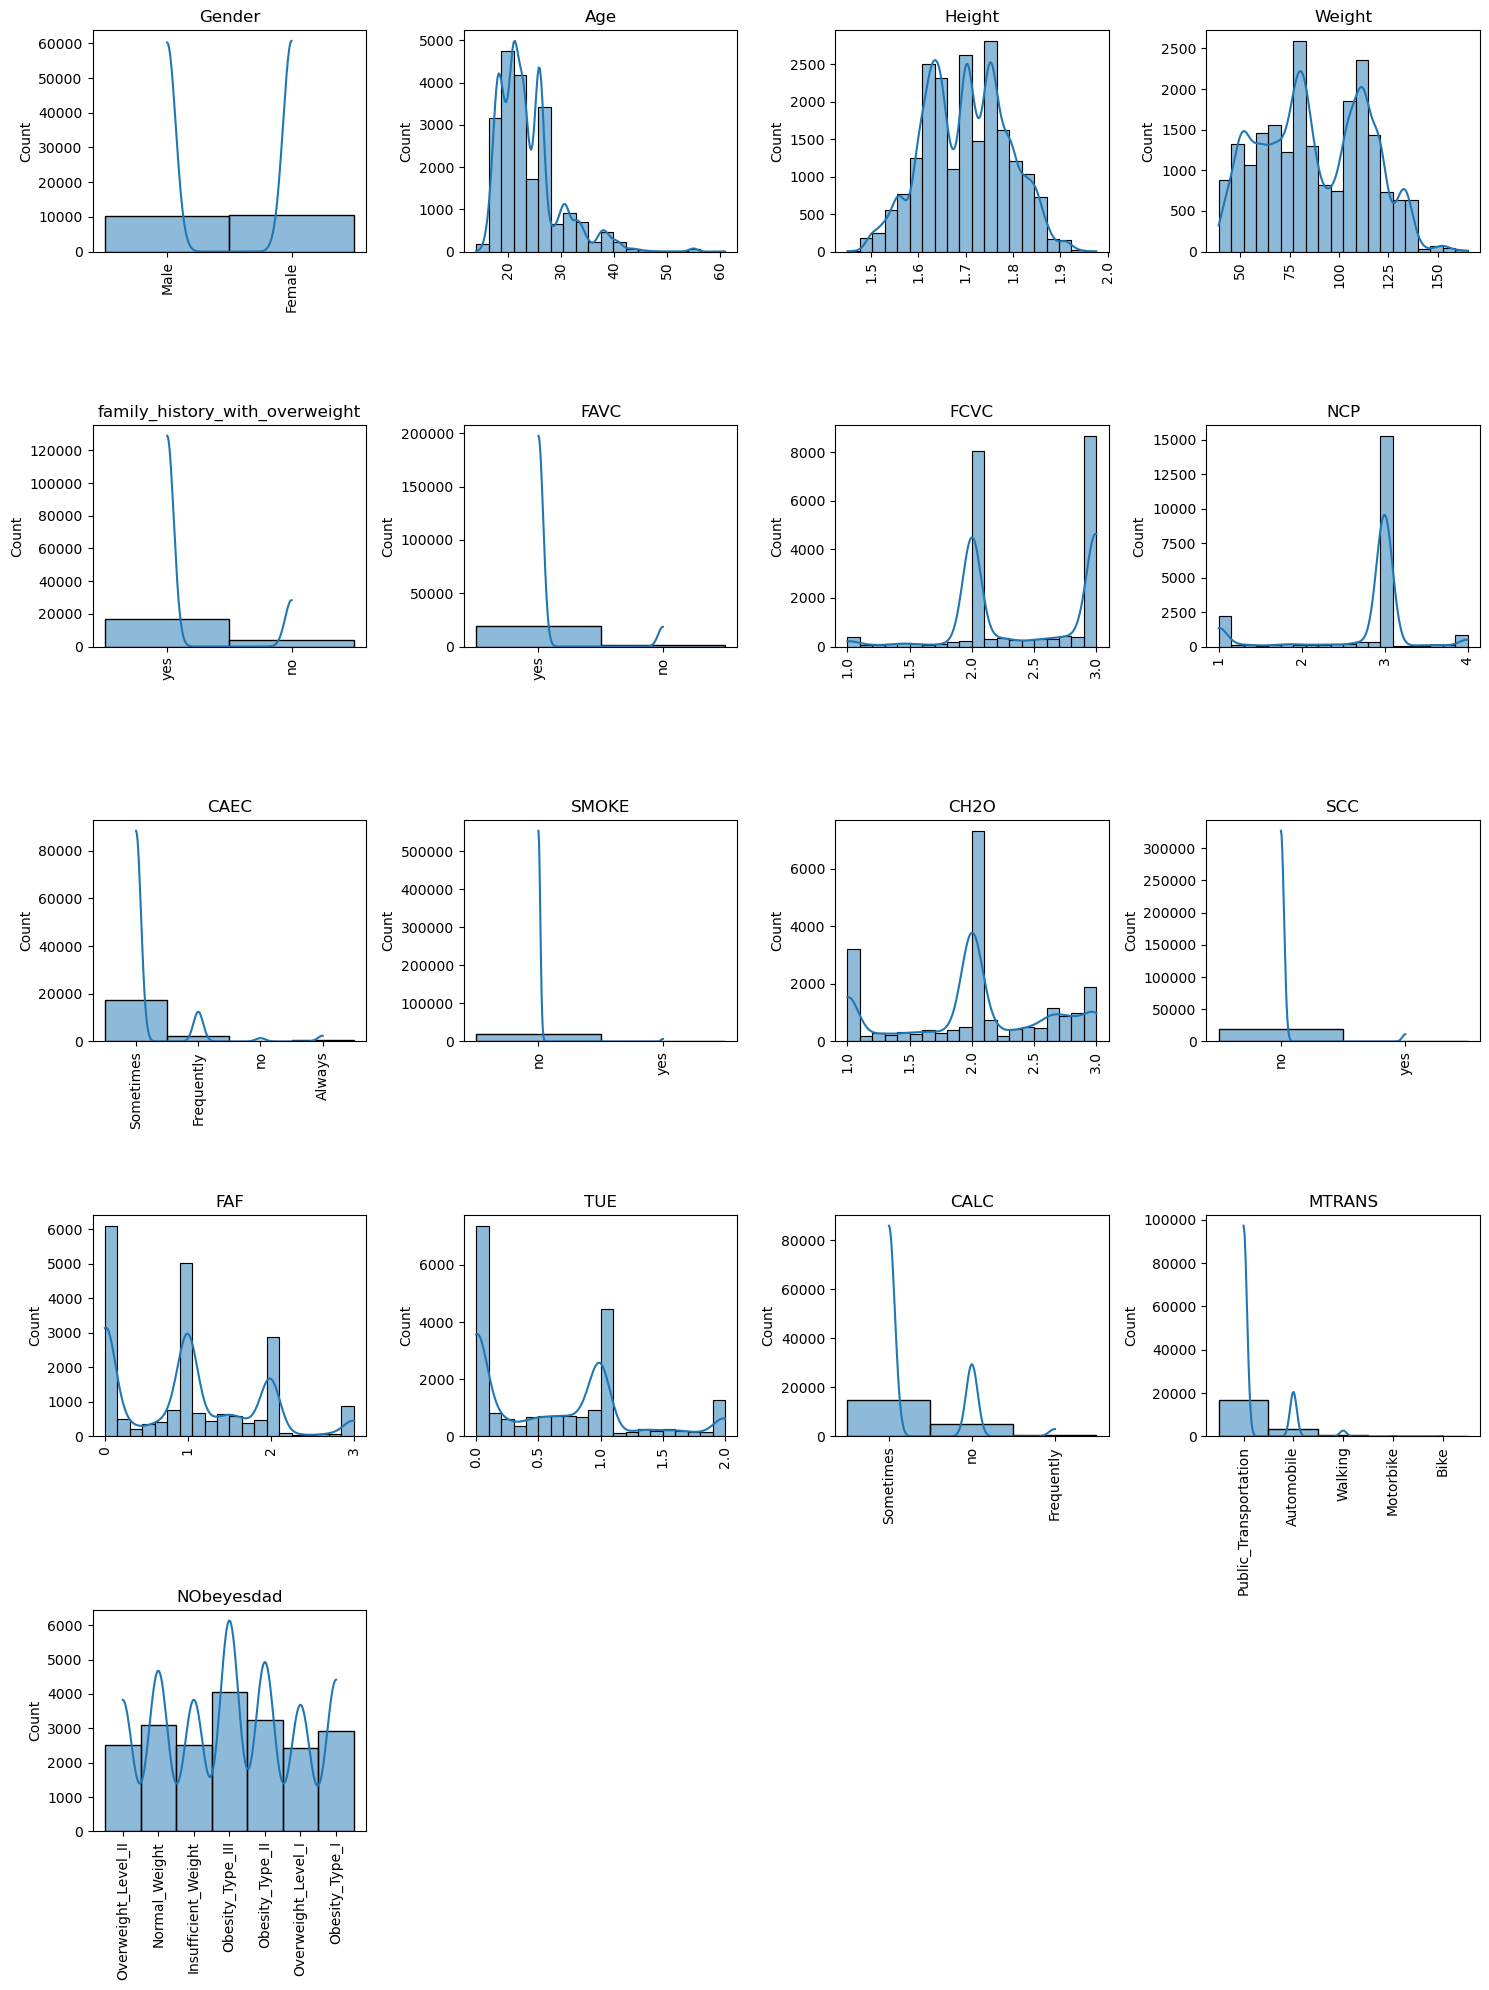

In [7]:

num_cols = len(df_copy.columns)
num_rows = (num_cols + 4) // 4  # Redondeo hacia arriba para asegurar suficientes filas
fig, axes = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))

# Aplanar el arreglo de ejes
axes = axes.flatten()

# Iterar sobre las columnas y crear histogramas con KDE
for i, col in enumerate(df_copy.columns):
    sns.histplot(data=df_copy[col], ax=axes[i], bins=20, kde=True)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_xlabel('')
    
# Eliminar ejes no utilizados
for j in range(num_cols, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<b>2.</b> Seeking for null values
* Building a heatmap to show null values (Null values should be appears as white spaces in the heatmap)

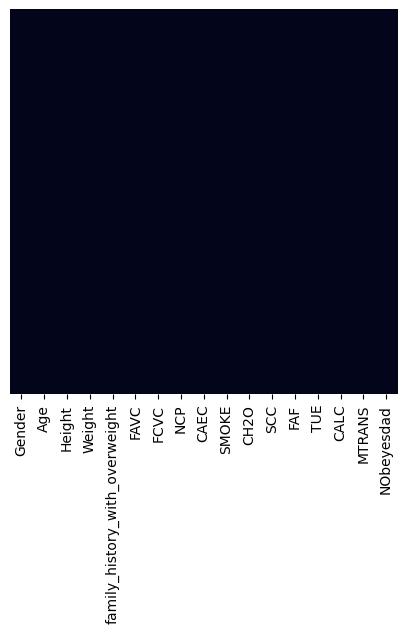

In [8]:
plt.figure(figsize=(5,5))
sns.heatmap(df_copy.isnull(), annot=False, cbar=False, yticklabels=False)
plt.show()

It seems we have not null values!, but to be fully sure, lets try to count null values

In [9]:
df_copy.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

### 4. Handling with numerical and categorical features
* Rounding or normalizing numeric values
* Apply encodig of features
* Builiding a heatmap for detect most important feartures

Numeric features

In [10]:
df_numeric = df_copy.dtypes == float
df_numerical = df_copy.loc[:, df_numeric]

In [11]:
df_numerical.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721


In [12]:
#Rounding Age feature
df["Age"] = round(df["Age"],0)

Categorical features

In [13]:
df_category = df_copy.dtypes == object
df_categorical = df_copy.loc[:, df_category]
df_categorical

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
0,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,yes,yes,Frequently,no,no,no,Automobile,Normal_Weight
2,Female,yes,yes,Sometimes,no,no,no,Public_Transportation,Insufficient_Weight
3,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...
20753,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_II
20754,Male,no,yes,Frequently,no,no,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,yes,yes,Sometimes,no,no,no,Public_Transportation,Obesity_Type_II
20756,Male,yes,yes,Sometimes,no,no,no,Automobile,Overweight_Level_II


We identified the follow features with a binary values that can be set to 1 or 0:
* Gender
* family_history_with_overweight
* FAVC
* SMOKE
* SCC

The follow features can be assigned 

In [14]:
df_categorical["Gender"] = df_categorical["Gender"].apply(lambda x: 1 if x == "Male" else 0)
df_categorical["family_history_with_overweight"] = df_categorical["family_history_with_overweight"].apply(lambda x: 1 if x == "yes" else 0)
df_categorical["FAVC"] = df_categorical["FAVC"].apply(lambda x: 1 if x=="yes" else 0)
df_categorical["SMOKE"] = df_categorical["SMOKE"].apply(lambda x: 1 if x == "yes" else 0)
df_categorical["SCC"] = df_categorical["SCC"].apply(lambda x: 1 if x == "yes" else 0)
df_categorical['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_categorical['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded = pd.get_dummies(df_categorical['MTRANS']).astype(int)
df_categorical.drop("MTRANS", axis=1, inplace=True)
df_categorical = pd.concat([df_categorical.iloc[:, 0:-1], df_encoded], axis=1)

In [15]:
df_features = pd.concat([df_numerical, df_categorical], axis=1)
df_features

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,Automobile,Bike,Motorbike,Public_Transportation,Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,1,1,1,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,1,1,2,0,0,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,1,1,1,0,0,0,0,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,1,1,1,0,0,1,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,1,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,1,1,1,1,0,0,1,0,0,0,1,0
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,1,0,1,2,0,0,1,0,0,0,1,0
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,1,1,1,1,0,0,0,0,0,0,1,0
20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,1,1,1,1,0,0,0,1,0,0,0,0


Encoding the <i>y</i> labels (classes to predict)

In [16]:
labels = df["NObeyesdad"].copy(deep=True)

classes_dict = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}
y_encoded = pd.DataFrame()
y_encoded["NObeyesdad"] = labels.map(classes_dict)
y_encoded

,NObeyesdad
0,3
1,1
2,0
3,6
4,3
...,...
20753,5
20754,0
20755,5
20756,3


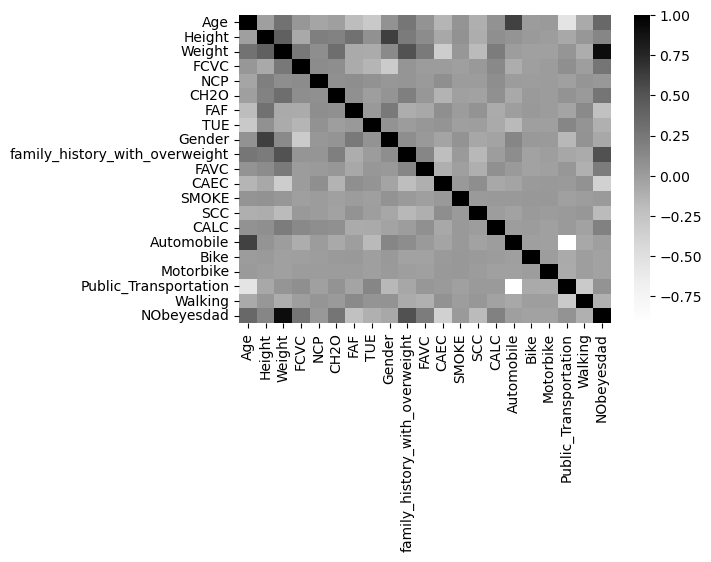

In [17]:
concat = pd.concat([df_features, y_encoded], axis=1)
plt.figure(figsize=(6,4))
sns.heatmap(concat.corr(), cmap="Greys")
plt.show()

In [18]:
# Calcular las correlaciones entre las características y la variable objetivo
correlations = concat.corrwith(concat["NObeyesdad"])

# Encontrar la característica con la menor correlación absoluta
feature_with_min_correlation = correlations.abs().idxmin()

print("Feature with the weakest correlation:", feature_with_min_correlation)
print("Correlation value:", correlations[feature_with_min_correlation])

Feature with the weakest correlation: Automobile
Correlación con la clase a predecir: -0.012772107634534862


In [19]:
correlations

Age                               0.356211
Height                            0.150141
Weight                            0.921250
FCVC                              0.272933
NCP                               0.027227
CH2O                              0.273154
FAF                              -0.234745
TUE                              -0.121009
Gender                           -0.067699
family_history_with_overweight    0.522026
FAVC                              0.215401
CAEC                             -0.364052
SMOKE                             0.013501
SCC                              -0.184959
CALC                              0.189361
Automobile                       -0.012772
Bike                             -0.028147
Motorbike                        -0.028868
Public_Transportation             0.062733
Walking                          -0.119828
NObeyesdad                        1.000000
dtype: float64

In [20]:
def transformingData(dataframe):
    df_numeric = dataframe.dtypes == float
    df_numerical = dataframe.loc[:, df_numeric]
    df_numerical["Age"] = round(df_numerical["Age"],0)
    
    df_category = dataframe.dtypes == object
    df_categorical = dataframe.loc[:, df_category]    
    df_categorical["Gender"] = df_categorical["Gender"].apply(lambda x: 1 if x == "Male" else 0)
    df_categorical["family_history_with_overweight"] = df_categorical["family_history_with_overweight"].apply(lambda x: 1 if x == "yes" else 0)
    df_categorical["FAVC"] = df_categorical["FAVC"].apply(lambda x: 1 if x=="yes" else 0)
    df_categorical["SMOKE"] = df_categorical["SMOKE"].apply(lambda x: 1 if x == "yes" else 0)
    df_categorical["SCC"] = df_categorical["SCC"].apply(lambda x: 1 if x == "yes" else 0)
    df_categorical['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_categorical['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    
    df_encoded = pd.get_dummies(df_categorical['MTRANS']).astype(int)
    try:
        df_categorical.drop(["MTRANS","NObeyesdad"], axis=1, inplace=True)
    except:
        df_categorical.drop(["MTRANS"], axis=1, inplace=True)
    df_categorical = pd.concat([df_categorical, df_encoded], axis=1)
    features = pd.concat([df_numerical, df_categorical], axis=1)

    return features

<b>4.</b> Checking if the classes are balanced or unbalanced:
* Lets make a bar plot to take a look if data contains imbalanced classes
* Are the difference significative?

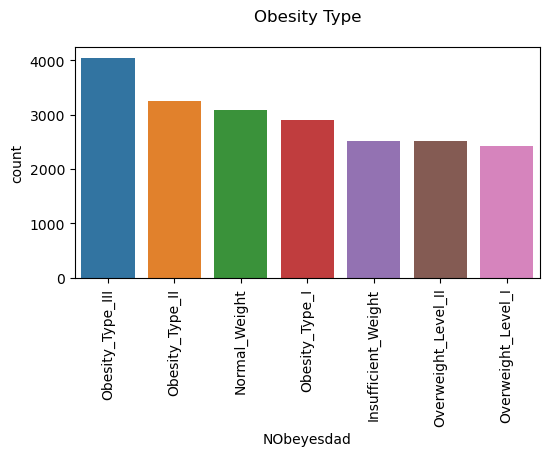

In [22]:
plt.figure(figsize=(6,3))
sns.barplot(x=df['NObeyesdad'].value_counts().index, y=df['NObeyesdad'].value_counts(), data= df)
plt.xticks(rotation=90)
plt.title("Obesity Type\n")
plt.show()

In [25]:
class_counts = df['NObeyesdad'].value_counts()

# Check if classes are balanced
if class_counts.std() < 0.05 * class_counts.mean():
    print("Classes are balanced.")
else:
    print("Classes are imbalanced.")

Classes are imbalanced.


### Training Model
* Testing models
* Evaluate Models

### Working with umbalanced classes

In [29]:
X = transformingData(df_copy)

In [30]:
labels = df_copy["NObeyesdad"].copy(deep=True)

classes_dict = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

y = pd.DataFrame()
y["NObeyesdad"] = labels.map(classes_dict)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       524
           1       0.82      0.89      0.85       626
           2       0.77      0.73      0.75       484
           3       0.79      0.79      0.79       514
           4       0.89      0.86      0.88       543
           5       0.97      0.98      0.98       657
           6       1.00      1.00      1.00       804

    accuracy                           0.89      4152
   macro avg       0.88      0.88      0.88      4152
weighted avg       0.89      0.89      0.89      4152



### With reducing the most respresentative class (Obesity_Type_III )

* Reducing classes with highest records for balancing all classes

In [33]:
instancias_categoria_a_reducir = df_copy[df_copy["NObeyesdad"] == "Obesity_Type_III"]
_, instancias_reducidas = train_test_split(instancias_categoria_a_reducir, test_size=0.195, random_state=42)

df_reduced = df_copy[~df_copy.isin(instancias_reducidas)].dropna()

In [34]:
X = transformingData(df_reduced)
labels = df_reduced["NObeyesdad"].copy(deep=True)
y = pd.DataFrame()
y["NObeyesdad"] = labels.map(classes_dict)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Random Forest Classifier

* Trying to find the best hyper parameters for Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en cada hoja de un árbol
    'bootstrap': [True, False]  # Método de muestreo de observaciones para construir árboles
}

# Crear un objeto RandomForestClassifier
clf = RandomForestClassifier()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda en cuadrícula
best_clf = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = best_clf.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Imprimir los mejores hiperparámetros encontrados
print("Best hyperparameters found for the RF classifier:")
print(grid_search.best_params_)

In [404]:
clf_rf = best_clf

In [ ]:
clf = RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split= 10, n_estimators= 200)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

2. XGBOOT

In [464]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [50, 100, 200, 500, 750],  # Número de árboles
    'max_depth': [3, 6, 9],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.3, 0.0999, 0.059, 0.38, 0.86],  # Tasa de aprendizaje
    'subsample': [0.5, 0.7, 1.0, 0.3,0.05],  # Submuestreo de filas
    'colsample_bytree': [0.5, 0.7, 1.0, 0.3, 0.15,0.05],  # Submuestreo de columnas
}

# Crear un objeto XGBClassifier
clf = XGBClassifier()
# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=6)

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda en cuadrícula
clf_xgb = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = clf_xgb.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

KeyboardInterrupt: 

In [544]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(colsample_bytree= 0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5)
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       503
           1       0.88      0.90      0.89       629
           2       0.82      0.79      0.80       516
           3       0.83      0.85      0.84       482
           4       0.93      0.90      0.91       618
           5       0.96      0.98      0.97       628
           6       1.00      1.00      1.00       618

    accuracy                           0.91      3994
   macro avg       0.91      0.91      0.91      3994
weighted avg       0.91      0.91      0.91      3994



In [512]:
reverse_classes_dict = {v: k for k, v in classes_dict.items()}
y_pred = pd.DataFrame(y_pred)
y_pred[0] = y_pred[0].map(reverse_classes_dict)
y_pred

,0
0,Obesity_Type_I
1,Normal_Weight
2,Obesity_Type_III
3,Overweight_Level_II
4,Overweight_Level_II
...,...
3989,Insufficient_Weight
3990,Obesity_Type_II
3991,Obesity_Type_I
3992,Insufficient_Weight


<b>Full XGB Model with balanced data (reducing the highest Class)</b>

In [617]:
def objective_xgb(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018]),
        'n_estimators': trial.suggest_int('n_estimators', 25, 750),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17]),
        'random_state': trial.suggest_categorical('random_state', [2020, 42, 15, 5, 1500]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.2, 0.1]),
#         'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 0.25, 0.2, 0.05, 0.18]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.12, 0.15, 0.1]),
#         'n_estimators': trial.suggest_int('n_estimators', 25, 750),
#         'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17,2,1, 25,32,]),
#         'random_state': trial.suggest_categorical('random_state', [2020, 42, 15]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)
study_xgb = optuna.create_study(direction='maximize')

study_xgb.optimize(objective_xgb, n_trials=500)

best_params_xgb = study_xgb.best_params

print("Best parameters for XGBoost:", best_params_xgb)

[I 2024-02-20 11:55:42,493] A new study created in memory with name: no-name-c857d48e-aaf3-4db2-bdb1-702986343c71
[I 2024-02-20 11:55:44,561] Trial 0 finished with value: 0.7736604907361042 and parameters: {'lambda': 1.3158566067161657, 'alpha': 0.20696280678308268, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 89, 'max_depth': 7, 'random_state': 1500, 'min_child_weight': 235}. Best is trial 0 with value: 0.7736604907361042.
[I 2024-02-20 11:55:52,923] Trial 1 finished with value: 0.814972458688032 and parameters: {'lambda': 0.5994114936594399, 'alpha': 1.973880537610062, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 379, 'max_depth': 7, 'random_state': 1500, 'min_child_weight': 219}. Best is trial 1 with value: 0.814972458688032.
[I 2024-02-20 11:56:14,224] Trial 2 finished with value: 0.9051076614922383 and parameters: {'lambda': 0.024623114582086724, 'alpha': 0.0016176330163192104, 'colsample_bytree': 0.9, 'su

[I 2024-02-20 12:03:43,461] Trial 23 finished with value: 0.9093640460691037 and parameters: {'lambda': 0.0024957897344294925, 'alpha': 0.0010879908531483832, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 728, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 1}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:04:04,650] Trial 24 finished with value: 0.8960941412118177 and parameters: {'lambda': 0.0015808246742831382, 'alpha': 0.0038068187787643573, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 649, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 91}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:04:31,212] Trial 25 finished with value: 0.9056084126189284 and parameters: {'lambda': 0.007631733190113207, 'alpha': 0.01716169351181564, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 745, 'max_depth': 15, 'random_state': 2020, 'min

[I 2024-02-20 12:12:59,779] Trial 47 finished with value: 0.9051076614922383 and parameters: {'lambda': 0.0014530235783353313, 'alpha': 0.0027593915933522427, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 678, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 34}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:13:26,382] Trial 48 finished with value: 0.9103655483224837 and parameters: {'lambda': 0.003746205198241469, 'alpha': 0.001510050298548075, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 557, 'max_depth': 17, 'random_state': 5, 'min_child_weight': 9}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:13:44,797] Trial 49 finished with value: 0.8945918878317476 and parameters: {'lambda': 0.0058566984991003926, 'alpha': 0.46626079939758436, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 607, 'max_depth': 17, 'random_state': 5, 'min_ch

[I 2024-02-20 12:21:27,526] Trial 71 finished with value: 0.9096144216324487 and parameters: {'lambda': 0.0035745187890610423, 'alpha': 0.0014142574857700487, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 557, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 1}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:21:52,411] Trial 72 finished with value: 0.9103655483224837 and parameters: {'lambda': 0.003966641942118303, 'alpha': 0.002601505359210923, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 595, 'max_depth': 13, 'random_state': 5, 'min_child_weight': 9}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:22:17,004] Trial 73 finished with value: 0.9088632949424136 and parameters: {'lambda': 0.0019242675567995343, 'alpha': 0.0010212677517501432, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 657, 'max_depth': 17, 'random_state': 5, 'min_ch

[I 2024-02-20 12:32:15,772] Trial 95 finished with value: 0.9058587881822734 and parameters: {'lambda': 0.005007173049208799, 'alpha': 0.0017222007140963204, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 257, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 15}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:32:37,660] Trial 96 finished with value: 0.9071106659989985 and parameters: {'lambda': 0.008828203517325092, 'alpha': 0.004516234900008772, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 658, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 34}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:33:04,574] Trial 97 finished with value: 0.9086129193790686 and parameters: {'lambda': 0.0018020483361012418, 'alpha': 0.009486006484228036, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 618, 'max_depth': 15, 'random_state': 5, 'min_ch

[I 2024-02-20 12:42:23,256] Trial 119 finished with value: 0.8848272408612919 and parameters: {'lambda': 0.03824797015098313, 'alpha': 0.001496522931109527, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 730, 'max_depth': 15, 'random_state': 15, 'min_child_weight': 98}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:42:39,191] Trial 120 finished with value: 0.8422633950926389 and parameters: {'lambda': 0.0017278273446991333, 'alpha': 0.0024498857412643803, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 719, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 263}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:43:05,299] Trial 121 finished with value: 0.9113670505758638 and parameters: {'lambda': 0.0011558138819925995, 'alpha': 0.001815372748522728, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.018, 'n_estimators': 683, 'max_depth': 15, 'random_state': 15

[I 2024-02-20 12:53:00,621] Trial 142 finished with value: 0.9106159238858288 and parameters: {'lambda': 0.002018072903550223, 'alpha': 0.0020735900370070794, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 727, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 9}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:53:27,487] Trial 143 finished with value: 0.9098647971957937 and parameters: {'lambda': 0.003784728329705136, 'alpha': 0.0015048870791354325, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 750, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 16}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 12:53:56,283] Trial 144 finished with value: 0.9106159238858288 and parameters: {'lambda': 0.0026504588330162164, 'alpha': 0.0038278008615056994, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 635, 'max_depth': 15, 'random_state': 5, 'mi

[I 2024-02-20 13:03:12,018] Trial 165 finished with value: 0.9083625438157236 and parameters: {'lambda': 0.001289669579904831, 'alpha': 0.0022065597354985157, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 675, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 24}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 13:03:38,730] Trial 166 finished with value: 0.9071106659989985 and parameters: {'lambda': 0.0011440403212780103, 'alpha': 0.0016676929835644583, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 650, 'max_depth': 15, 'random_state': 15, 'min_child_weight': 18}. Best is trial 11 with value: 0.9126189283925888.
[I 2024-02-20 13:04:08,300] Trial 167 finished with value: 0.9106159238858288 and parameters: {'lambda': 0.005197563082275527, 'alpha': 0.0011565128393138501, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 717, 'max_depth': 15, 'random_state': 5, '

[I 2024-02-20 13:15:37,692] Trial 189 finished with value: 0.9121181772658988 and parameters: {'lambda': 0.6742049262310071, 'alpha': 0.011581431497523807, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 707, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:16:19,554] Trial 190 finished with value: 0.9126189283925888 and parameters: {'lambda': 0.6059547477261729, 'alpha': 0.012462621266239232, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 707, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:16:46,111] Trial 191 finished with value: 0.9108662994491737 and parameters: {'lambda': 0.5463291436129082, 'alpha': 0.014977408415334488, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 707, 'max_depth': 11, 'random_state': 5, 'min_child_wei

[I 2024-02-20 13:30:43,274] Trial 213 finished with value: 0.9123685528292439 and parameters: {'lambda': 0.3161803238011903, 'alpha': 0.014632766661478105, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 698, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 7}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:31:12,525] Trial 214 finished with value: 0.9111166750125188 and parameters: {'lambda': 0.34460596521831827, 'alpha': 0.011516501196934018, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 695, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 10}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:31:47,522] Trial 215 finished with value: 0.9098647971957937 and parameters: {'lambda': 0.412278135321455, 'alpha': 0.01405553025134028, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 729, 'max_depth': 11, 'random_state': 42, 'min_child_we

[I 2024-02-20 13:42:19,045] Trial 237 finished with value: 0.9036054081121683 and parameters: {'lambda': 0.5508684862974867, 'alpha': 0.004402688400554509, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 74, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:42:49,276] Trial 238 finished with value: 0.9118678017025539 and parameters: {'lambda': 0.47000981223049115, 'alpha': 0.006587636422167915, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 738, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 6}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:43:11,812] Trial 239 finished with value: 0.9098647971957937 and parameters: {'lambda': 0.21139916391179295, 'alpha': 0.005660106501742274, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 750, 'max_depth': 11, 'random_state': 5, 'min_child_w

[I 2024-02-20 13:54:53,286] Trial 261 finished with value: 0.9121181772658988 and parameters: {'lambda': 2.2376938545506473, 'alpha': 0.009725560266154764, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 737, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 10}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:55:21,880] Trial 262 finished with value: 0.9121181772658988 and parameters: {'lambda': 0.662647470370421, 'alpha': 0.004830554751307336, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 717, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 6}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 13:55:42,589] Trial 263 finished with value: 0.9068602904356535 and parameters: {'lambda': 1.3256065524833474, 'alpha': 0.011706612592319006, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 728, 'max_depth': 7, 'random_state': 5, 'min_child_weig

[I 2024-02-20 15:16:05,243] Trial 285 finished with value: 0.9106159238858288 and parameters: {'lambda': 0.47504098008629986, 'alpha': 0.019744429385427986, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 709, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 6}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:16:46,376] Trial 286 finished with value: 0.9118678017025539 and parameters: {'lambda': 0.6047369720281438, 'alpha': 0.005034970038922737, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 749, 'max_depth': 11, 'random_state': 1500, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:17:16,520] Trial 287 finished with value: 0.9091136705057586 and parameters: {'lambda': 0.7312048206032834, 'alpha': 0.003270594546114331, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 725, 'max_depth': 11, 'random_state': 5, 'min_child

[I 2024-02-20 15:26:04,854] Trial 309 finished with value: 0.9093640460691037 and parameters: {'lambda': 1.0790719421644102, 'alpha': 0.01242595219967091, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 692, 'max_depth': 5, 'random_state': 1500, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:26:39,824] Trial 310 finished with value: 0.9113670505758638 and parameters: {'lambda': 0.20351336949965038, 'alpha': 0.017752574938454422, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 728, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 12}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:27:12,743] Trial 311 finished with value: 0.9103655483224837 and parameters: {'lambda': 0.6415812419910688, 'alpha': 0.014347715591156485, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 714, 'max_depth': 11, 'random_state': 42, 'min_child

[I 2024-02-20 15:38:26,945] Trial 333 finished with value: 0.913119679519279 and parameters: {'lambda': 0.9862750262518726, 'alpha': 0.004277489797988131, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 733, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:38:52,770] Trial 334 finished with value: 0.9108662994491737 and parameters: {'lambda': 1.0280239738930685, 'alpha': 0.0044674889321045744, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 733, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 10}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:39:20,581] Trial 335 finished with value: 0.9123685528292439 and parameters: {'lambda': 1.1845400644204422, 'alpha': 0.004034942908167876, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 736, 'max_depth': 11, 'random_state': 5, 'min_child_we

[I 2024-02-20 15:49:37,697] Trial 357 finished with value: 0.9116174261392088 and parameters: {'lambda': 0.08093837787908974, 'alpha': 0.003429307105792612, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 727, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:49:48,273] Trial 358 finished with value: 0.900100150225338 and parameters: {'lambda': 2.328808315412164, 'alpha': 0.01150670452702255, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 326, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 17}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 15:50:14,247] Trial 359 finished with value: 0.9126189283925888 and parameters: {'lambda': 1.709289246254094, 'alpha': 0.006250103968188821, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 699, 'max_depth': 11, 'random_state': 5, 'min_child_we

[I 2024-02-20 16:01:17,601] Trial 381 finished with value: 0.9103655483224837 and parameters: {'lambda': 0.9000357044181002, 'alpha': 0.014487835373236505, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.012, 'n_estimators': 278, 'max_depth': 11, 'random_state': 15, 'min_child_weight': 6}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:01:56,453] Trial 382 finished with value: 0.9121181772658988 and parameters: {'lambda': 1.1591178400907785, 'alpha': 0.006682683395957195, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 726, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:02:19,152] Trial 383 finished with value: 0.9098647971957937 and parameters: {'lambda': 6.502131942570907, 'alpha': 0.002852709311043819, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 714, 'max_depth': 11, 'random_state': 5, 'min_child_

[I 2024-02-20 16:12:40,457] Trial 405 finished with value: 0.9043565348022033 and parameters: {'lambda': 1.0109155571223403, 'alpha': 0.003957505697151388, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 740, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 55}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:13:05,054] Trial 406 finished with value: 0.9093640460691037 and parameters: {'lambda': 1.1680936938791908, 'alpha': 0.0030059685814484024, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 748, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 21}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:13:33,692] Trial 407 finished with value: 0.9111166750125188 and parameters: {'lambda': 0.8394258935303, 'alpha': 0.004225632449167498, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 750, 'max_depth': 11, 'random_state': 5, 'min_child_weig

[I 2024-02-20 16:23:48,688] Trial 429 finished with value: 0.9061091637456185 and parameters: {'lambda': 1.9594300624675236, 'alpha': 0.009731059797872879, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 750, 'max_depth': 11, 'random_state': 15, 'min_child_weight': 22}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:24:23,123] Trial 430 finished with value: 0.9113670505758638 and parameters: {'lambda': 0.7329020295030253, 'alpha': 0.005501230100780252, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 712, 'max_depth': 9, 'random_state': 5, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:24:53,071] Trial 431 finished with value: 0.9056084126189284 and parameters: {'lambda': 0.9835031487802113, 'alpha': 0.011707895381327592, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 729, 'max_depth': 11, 'random_state': 5, 'min_child_we

[I 2024-02-20 16:34:51,077] Trial 453 finished with value: 0.9108662994491737 and parameters: {'lambda': 1.5196248068532223, 'alpha': 0.0030339220098881564, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 749, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 8}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:35:09,847] Trial 454 finished with value: 0.900851276915373 and parameters: {'lambda': 1.213589773465415, 'alpha': 0.004433715620772484, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 750, 'max_depth': 5, 'random_state': 5, 'min_child_weight': 21}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:35:46,668] Trial 455 finished with value: 0.9106159238858288 and parameters: {'lambda': 0.47541634580737313, 'alpha': 0.0172523411321398, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 686, 'max_depth': 11, 'random_state': 15, 'min_child_wei

[I 2024-02-20 16:46:31,735] Trial 477 finished with value: 0.9076114171256885 and parameters: {'lambda': 1.0551358156157853, 'alpha': 0.0028705033614574165, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 737, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 1}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:46:58,631] Trial 478 finished with value: 0.9086129193790686 and parameters: {'lambda': 1.4893932756573243, 'alpha': 0.003990156821847293, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 712, 'max_depth': 11, 'random_state': 5, 'min_child_weight': 22}. Best is trial 171 with value: 0.913620430645969.
[I 2024-02-20 16:47:33,788] Trial 479 finished with value: 0.913119679519279 and parameters: {'lambda': 0.920482846372777, 'alpha': 0.0023447731200567493, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 750, 'max_depth': 11, 'random_state': 5, 'min_child_we

Best parameters for XGBoost: {'lambda': 0.0016013531136927785, 'alpha': 0.0012681603011618727, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 707, 'max_depth': 15, 'random_state': 5, 'min_child_weight': 8}


clf_xgb = XGBClassifier(colsample_bytree= 0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5)
clf_xgb.fit(X, y)

* 2nd model

In [597]:
clf_xgb = XGBClassifier(alpha=3.380307278107612, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0033746639432563493,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=222,
              n_jobs=None)
clf_xgb.fit(X, y)

XGBClassifier(alpha=0.6961623137841844, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0026409082880366826,
              learning_rate=0.018, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=11,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=453,
              n_jobs=None, ...)

* 3rd model 0.9123685528292439

In [607]:
clf_xgb = XGBClassifier(alpha=3.380307278107612, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda = 0.0033746639432563493,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=222,
              n_jobs=None)
clf_xgb.fit(X, y)

SyntaxError: invalid syntax (3135513320.py, line 6)

In [610]:
study_xgb.best_params

{'lambda': 0.0010283590728950918,
 'alpha': 0.9100443454199918,
 'colsample_bytree': 0.6,
 'subsample': 0.7,
 'learning_rate': 0.12,
 'n_estimators': 550,
 'max_depth': 13,
 'random_state': 15,
 'min_child_weight': 41}

In [603]:
clf_xgb = XGBClassifier(**study_xgb.best_params)
clf_xgb.fit(X, y)

XGBClassifier(alpha=3.380307278107612, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0033746639432563493,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=222,
              n_jobs=None, ...)

* 5 model 0.9133700550826239

In [613]:
best_params_xgb #best params for model num 5

{'lambda': 0.401315595718053,
 'alpha': 0.002055277502886379,
 'colsample_bytree': 0.4,
 'subsample': 0.6,
 'learning_rate': 0.018,
 'n_estimators': 704,
 'max_depth': 13,
 'random_state': 2020,
 'min_child_weight': 6}

In [615]:
clf_xgb = XGBClassifier(**best_params_xgb)
clf_xgb.fit(X, y)

XGBClassifier(alpha=0.002055277502886379, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.401315595718053,
              learning_rate=0.018, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=704,
              n_jobs=None, ...)

* 6th model with 0.913620430645969

In [618]:
best_params_xgb #best params for model num 6

{'lambda': 0.0016013531136927785,
 'alpha': 0.0012681603011618727,
 'colsample_bytree': 0.7,
 'subsample': 0.6,
 'learning_rate': 0.018,
 'n_estimators': 707,
 'max_depth': 15,
 'random_state': 5,
 'min_child_weight': 8}

In [619]:
clf_xgb = XGBClassifier(**best_params_xgb)
clf_xgb.fit(X, y)

XGBClassifier(alpha=0.0012681603011618727, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0016013531136927785,
              learning_rate=0.018, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=8, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=707,
              n_jobs=None, ...)

* 4th model 0.9121181772658988

In [606]:
clf_xgb = XGBClassifier(**study_xgb.best_params)
clf_xgb.fit(X, y)

XGBClassifier(alpha=0.9100443454199918, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0010283590728950918,
              learning_rate=0.12, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=41, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=550,
              n_jobs=None, ...)

In [620]:
X_submit = pd.read_csv("test/test.csv")
ids = X_submit["id"]
X_submit = X_submit.drop("id", axis=1)
X_submit = transformingData(X_submit)
X_submit = X_submit.reindex(columns=X.columns)
y_submit = clf_xgb.predict(X_submit)
y_submit = pd.DataFrame(y_submit)
y_submit["NObeyesdad"] = y_submit[0].map(reverse_classes_dict)
results = pd.concat([ids, y_submit["NObeyesdad"]], axis=1)
results.to_csv("./results.csv", index=None)

3. LightGBM

In [457]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import classification_report

# Definir los hiperparámetros que deseas ajustar
param_distributions = {
    'learning_rate': [0.05, 0.1, 0.3, 0.15, 0.07, 0.03,],  # Tasa de aprendizaje
    'n_estimators': [50, 100, 200, 500, 550,  750],  # Número de estimadores (árboles)
    'max_depth': [3, 6, 9, 12, 1, 15],  # Profundidad máxima de los árboles
    'min_child_samples': [2, 5, 10, 20],  # Número mínimo de muestras requeridas en cada hoja de un árbol
    'subsample': [0.6, 0.8, 1.0, 0.4, 0.2, 0.15, 0.05],  # Tamaño de la muestra para entrenar cada árbol
}

# Crear un objeto LGBMClassifier
clf = lgb.LGBMClassifier()

# Crear un objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_distributions, 
                                   n_iter=20, cv=8, scoring='accuracy', n_jobs=8, random_state=42)

# Ejecutar la búsqueda aleatoria en los datos de entrenamiento
random_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda aleatoria
clf_lgbm = random_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = clf_lgbm.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados para LightGBM:")
print(random_search.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 15975, number of used features: 20
[LightGBM] [Info] Start training from score -2.067927
[LightGBM] [Info] Start training from score -1.873713
[LightGBM] [Info] Start training from score -2.123398
[LightGBM] [Info] Start training from score -2.058075
[LightGBM] [Info] Start training from score -1.941600
[LightGBM] [Info] Start training from score -1.807851
[LightGBM] [Info] Start training from score -1.800625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [461]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(subsample=0.2, n_estimators=500, min_child_samples=20, max_depth=3, learning_rate=0.04)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 15975, number of used features: 20
[LightGBM] [Info] Start training from score -2.067927
[LightGBM] [Info] Start training from score -1.873713
[LightGBM] [Info] Start training from score -2.123398
[LightGBM] [Info] Start training from score -2.058075
[LightGBM] [Info] Start training from score -1.941600
[LightGBM] [Info] Start training from score -1.807851
[LightGBM] [Info] Start training from score -1.800625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       503
           1       0.88      0.90      0.89       629
           2       0.82      0.78      0.80       516
           3       0.82      0.85      0.83       482
           4       0.93      0.90      0.91       618
           5       0.97      0.98      0.97       628
           6       1.00      0.99      1.00       618

    accuracy                           0.91      3994
   macro avg       0.91      0.91      0.91      3994
weighted avg       0.91      0.91      0.91      3994



4. GradientBoosting

In [413]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de estimadores (árboles)
    'learning_rate': [0.01, 0.1, 0.3],  # Tasa de aprendizaje
    'max_depth': [3, 6, 9],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en cada hoja de un árbol
}

# Crear un objeto GradientBoostingClassifier
clf = GradientBoostingClassifier()

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, scoring='accuracy', n_jobs=-1)

# Ejecutar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda en cuadrícula
clf_gb = grid_search.best_estimator_

# Hacer predicciones en el conjunto de prueba con el mejor modelo
y_pred = clf_gb.predict(X_test)

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

KeyboardInterrupt: 

In [411]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       503
           1       0.88      0.88      0.88       629
           2       0.80      0.76      0.78       516
           3       0.80      0.84      0.82       482
           4       0.93      0.89      0.91       618
           5       0.97      0.98      0.97       628
           6       1.00      1.00      1.00       618

    accuracy                           0.91      3994
   macro avg       0.90      0.90      0.90      3994
weighted avg       0.91      0.91      0.91      3994



voting_clf

In [462]:
#clf_lgbm = lgb.LGBMClassifier()
clf_lgbm = lgb.LGBMClassifier(subsample=0.2, n_estimators=500, min_child_samples=20, max_depth=3, learning_rate=0.04)
clf_xgb = XGBClassifier(colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5)
clf_gb = GradientBoostingClassifier()
clf_rf = best_clf

voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb), ('rf', clf_rf)], 
                              voting='soft')

voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 15975, number of used features: 20
[LightGBM] [Info] Start training from score -2.067927
[LightGBM] [Info] Start training from score -1.873713
[LightGBM] [Info] Start training from score -2.123398
[LightGBM] [Info] Start training from score -2.058075
[LightGBM] [Info] Start training from score -1.941600
[LightGBM] [Info] Start training from score -1.807851
[LightGBM] [Info] Start training from score -1.800625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(learning_rate=0.04, max_depth=3,
                                             n_estimators=500, subsample=0.2)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gam...
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('gb', GradientBoostingClassifier()),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=20,
                                                     min_samples_split=10,
                                                     n_estimators=200))],
                 voting='soft')

In [463]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       503
           1       0.88      0.90      0.89       629
           2       0.81      0.78      0.79       516
           3       0.81      0.85      0.83       482
           4       0.94      0.89      0.91       618
           5       0.97      0.98      0.97       628
           6       1.00      1.00      1.00       618

    accuracy                           0.91      3994
   macro avg       0.91      0.91      0.91      3994
weighted avg       0.91      0.91      0.91      3994



In [451]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

# Cargar el conjunto de datos Iris como ejemplo
iris = load_iris()
X = iris.data
y = iris.target

# Crear un clasificador Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Realizar validación cruzada con 5 pliegues
scores = cross_val_score(clf, X, y, cv=5)

# Imprimir los resultados de la validación cruzada
print("Puntuaciones de la validación cruzada:", scores)
print("Precisión promedio:", scores.mean())


Puntuaciones de la validación cruzada: [0.96666667 0.96666667 0.93333333 0.96666667 1.        ]
Precisión promedio: 0.9666666666666668
